Importing Functions

In [153]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

LOADING THE DATASET

In [154]:
# Import the data
df = pd.read_csv('/Users/elvisechefu/Desktop/language detection/languages.csv')
#df.head()


DATA ANALYSIS

In [155]:
# Get all unique languages values
print(df.groupby('language').nunique())
print(f"Total Length of dataset: {len(df)}")


# Check for missing values
print(df.isnull().sum())


# Explore the columns and their types
print(df.info())

            text
language        
english   275687
french    169693
german    199618
spanish   118686
Total Length of dataset: 763684
text        0
language    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763684 entries, 0 to 763683
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      763684 non-null  object
 1   language  763684 non-null  object
dtypes: object(2)
memory usage: 11.7+ MB
None


ONEHOT_ENCODING

In [156]:
# Encode language column
# le = preprocessing.LabelEncoder()
# le.fit(df['language'])
# df['language'] = le.transform(df['language'])
# le.classes_

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip (columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df , dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

df = onehot_encode(
    df,
    columns=['language'],
    prefixes=['lan']
)


In [157]:
#df.head()

DATA VISUALIZATION

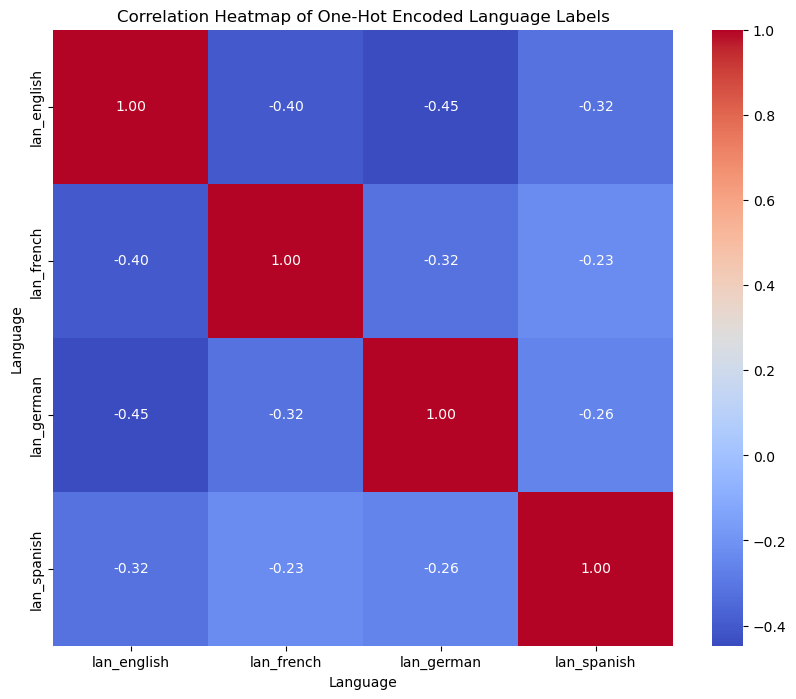

In [158]:
#Represnting the data in a heta-map as a form of visualisation

import seaborn as sns
import matplotlib.pyplot as plt

language_columns = [col for col in df.columns if col.startswith('lan_')]

# Calculate the correlation matrix
correlation_matrix = df[language_columns].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of One-Hot Encoded Language Labels')
plt.xlabel('Language')
plt.ylabel('Language')
plt.show()

SPLITTING INTO TRAIN, VALIDATE AND TEST SET

In [159]:
y = df.drop('text', axis=1)
X = df['text']
#X.head()

In [160]:
#y.head()

In [161]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y , test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [162]:
# Print the shapes of the resulting sets
#print("Shape of X_train_combined:", X_train.shape)
#print("Shape of y_train_combined:", y_train.shape)
#print("Shape of X_val:", X_val.shape)
#print("Shape of y_val:", y_val.shape)
#print("Shape of X_test:", X_test.shape)
#print("Shape of y_test:", y_test.shape)

CONVERTING FROM THE PANDAS DATAFRAME TO TENSORFLOW

In [163]:
# Turn pandas dataframe into TensorFlow Dataset
raw_train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
raw_val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
raw_test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

CREATING BATCH SIZES IN THE TENSORFLOW DATASET

In [164]:
# Create batches
batch_size = 50
raw_train_dataset = raw_train_dataset.batch(batch_size)
raw_val_dataset = raw_val_dataset.batch(batch_size)
raw_test_dataset = raw_test_dataset.batch(batch_size)

CROSS-CHECKING THE REVIEWS OF THE SPLIT SETS 

In [165]:
# Print three labels as example
for text_batch, label_batch in raw_train_dataset.take(1):
    for i in range(3):
       print('Training Review:', text_batch.numpy()[i])
       print("Training Label:", label_batch.numpy()[i])

for text_batch, label_batch in raw_val_dataset.take(1):
    for i in range(3):
       print('Validation Review:', text_batch.numpy()[i])
       print("Validation Label:", label_batch.numpy()[i])

Training Review: b'navegamos hacia el sur'
Training Label: [False False False  True]
Training Review: b'ce fut notre rencontre initiale'
Training Label: [False  True False False]
Training Review: b'tom hocha la t\xc3\xaate rapidement'
Training Label: [False  True False False]
Validation Review: b'wir versuchen es'
Validation Label: [False False  True False]
Validation Review: b'die schnurrende katze rieb sich an toms bein'
Validation Label: [False False  True False]
Validation Review: b'nous navons pas eu dautres choix que dappeler la police la nuit derni\xc3\xa8re'
Validation Label: [False  True False False]


ANALYSIS

In [166]:
# Get number of unique words in entire dataset
from collections import Counter

results = Counter()
df['text'].str.split().apply(results.update)  # Very computer intensive method
len(results)

104611

IMPLEMENTAION OF MAX_FEATURES AND SEQUENCE LENGTH

In [167]:
max_features = 50000  # Total words to vectorize
sequence_length = 20  # The length of a sentence

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Take a smaller sample for adaptation
sample_size = 1000  # Choose an appropriate size based on your dataset size
subset_for_adaptation = df['text'].sample(n=sample_size)

# Adapt to the smaller subset
vectorize_layer.adapt(subset_for_adaptation)

VECTORIZING THE SAMPLE SIZE CREATED 

In [168]:
# Function to vectorize text
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.dtypes.cast(vectorize_layer(text), tf.float32)

RETRIVING THE REST OF THE DATA FROM THE BATCH

In [169]:
# Retrieve a batch from the dataset
text_batch, label_batch = next(iter(raw_test_dataset))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", first_label)
print("Vectorized review:", vectorize_text(first_review))

Review: tf.Tensor(b'the grass is always greener on the other side of the fence', shape=(), dtype=string)
Label: tf.Tensor([ True False False False], shape=(4,), dtype=bool)
Vectorized review: tf.Tensor(
[[1.000e+01 1.882e+03 1.900e+01 2.850e+02 1.000e+00 4.800e+01 1.000e+01
  1.402e+03 4.860e+02 2.500e+01 1.000e+01 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]], shape=(1, 20), dtype=float32)


APPLICATION OF THE TEXTVECTORIZATION TO THE REST OF THE DATASET

In [170]:
# Apply the TextVectorization step to the train and test dataset
train_ds = raw_train_dataset.map(lambda x,y: (vectorize_text(x), y))
val_ds = raw_val_dataset.map(lambda x, y: (vectorize_text(x), y))
test_ds = raw_test_dataset.map(lambda x ,y: (vectorize_text(x) , y))

APPLICATION OF AUTOTUNE

In [171]:
# Performance measures
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

MODEL CREATION

In [172]:
tf.keras.backend.clear_session()

embedding_dim = 32 

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim, input_length=20), 
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(4, activation=tf.nn.softmax), 
    layers.Dropout(0.5),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            1600032   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                        

MODEL COMPILATION

In [173]:
model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

TRAINING THE MODEL ON THE TRAIN SET

In [174]:
epochs = 1
history = model.fit(train_ds, epochs=epochs)


8019/8019 [==============================] - 40s 5ms/step - loss: nan - accuracy: 0.5127


EVALUATING ON THE TRAIN SET

In [175]:
loss, accuracy = model.evaluate(train_ds)
print("train accuracy:", accuracy)

8019/8019 [==============================] - 3s 333us/step - loss: 0.0356 - accuracy: 0.9858
train accuracy: 0.9857781529426575


EVALUATING ON THE VALIDATION SET

In [176]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation accuracy:", val_accuracy)


2673/2673 [==============================] - 1s 352us/step - loss: 0.0371 - accuracy: 0.9856
Validation accuracy: 0.985566258430481


EVALUATING ON THE TEST SET

In [177]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

4583/4583 [==============================] - 2s 353us/step - loss: 0.0367 - accuracy: 0.9860
Test accuracy: 0.9859715700149536


PLOTTING THE ACCURACY GRAPH OF ALL ACCRURACIES TO CHECK FOR OVERFITTING

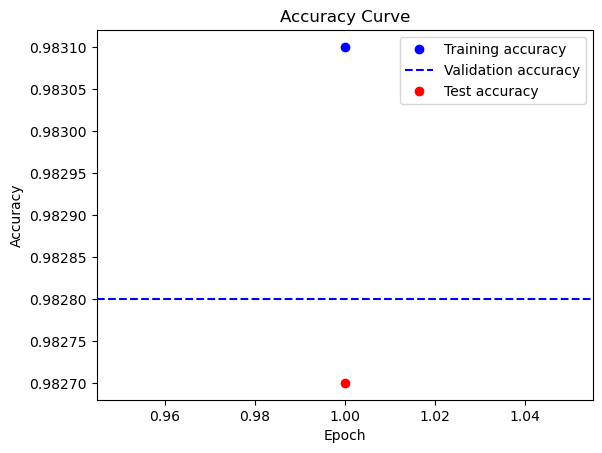

In [178]:
import matplotlib.pyplot as plt

def plot_accuracy_curve(train_accuracy, val_accuracy, test_accuracy=None):
    epochs = range(1, len(train_accuracy) + 1)
    plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
    if val_accuracy is not None:
        plt.axhline(y=val_accuracy, color='b', linestyle='--', label='Validation accuracy')
    if test_accuracy is not None:
        plt.plot(len(train_accuracy), test_accuracy, 'ro', label='Test accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage:
train_accuracy = [0.9831]  # Your train accuracy result
val_accuracy = 0.9828  # Your validation accuracy result
test_accuracy = 0.9827  # Your test accuracy result

plot_accuracy_curve(train_accuracy, val_accuracy, test_accuracy)


TESTING IN GERMAN

In [179]:
to_predict = ["Deutschland ist für seine reiche Kultur und Geschichte bekannt. Berlin, die Hauptstadt, ist ein Zentrum für Kunst, Musik und Geschichte. Die deutsche Küche, mit Gerichten wie Bratwurst und Sauerkraut, ist auch weltweit beliebt."] # [0,0,1,0] (German)
# Vectorize text before giving it to the model
to_predict = vectorize_layer(to_predict)
prediction = model.predict(to_predict)

classes = ["English", "French", "German", "Spanish"]

highest_prediction = tf.math.argmax(prediction, 1).numpy()

print(classes[highest_prediction[0]])
print(f"Certainty: {prediction[0][highest_prediction][0] * 100}%")

1/1 [==============================] - 0s 34ms/step
German
Certainty: 100.0%


TESTING IN FRENCH

In [180]:
to_predict = ["cállate tu boca huele"]
prediction = model.predict(vectorize_layer(to_predict))
print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")

1/1 [==============================] - 0s 13ms/step
Predicted Language: French, Certainty: 82.22%


TESTING IN SPANISH

In [181]:
to_predict = ["El clima en España varía según la región. En el norte, llueve más y hace más fresco, mientras que en el sur es más seco y caluroso. Las playas del Mediterráneo son populares en verano"]
prediction = model.predict(vectorize_layer(to_predict))
print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")

1/1 [==============================] - 0s 12ms/step
Predicted Language: Spanish, Certainty: 100.00%


TESTING THE MODEL IN ENGLISH TEXTS

In [182]:
to_predict = ["I can't fucking sleep with this much deadlines to submit "]
prediction = model.predict(vectorize_layer(to_predict))
print(f"Predicted Language: {classes[prediction.argmax()]}, Certainty: {100 * prediction.max():.2f}%")

1/1 [==============================] - 0s 18ms/step
Predicted Language: English, Certainty: 100.00%
